# Mask R-CNN - Train on IE Dataset

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import importlib
import skimage
import json
import wandb
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug import parameters as iap

# Following lines were sometimes needed to be able to train on a Nvidia RTX 2060 super.
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#sess = tf.Session(config=config)

#config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.9
#tf.keras.backend.set_session(tf.Session(config=config));

# Right now, this line does the trick.
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# See if GPU has been detected.
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
importlib.reload(modellib)
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11278042962621077623
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 17929706773430195263
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13037241822877615726
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7395521332
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14824296772823747472
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


Using TensorFlow backend.


## Configurations

In [2]:
class IEConfig(Config):
    """
    Configuration for training on the IE dataset.
    Derives from the base Config class and overrides values specific
    to the IE dataset.
    """
    NAME = "InteractiveElementsOneClass"

    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Only one class for all elements.
    CLASSES = ["IE"]
    # Number of classes (including background)
    NUM_CLASSES = 1 + len(CLASSES)
    
    DATASET_PATH = "dataset/"

    # Apply the following augmentations in series.
    # Order is needed to aquire a uniform background
    # because changing color first and rotating afterwards
    # results in a visible rotated rectangle in front of a black background.
    AUGMENTATION = iaa.Sequential([
        iaa.Sometimes(0.5,
            iaa.Affine(
                scale=(0.8, 1),
                rotate=iap.Normal(0, 3)
            )
        ),
        iaa.Sometimes(0.5,
            iaa.LinearContrast((0.8, 1.2))
        ),
        iaa.Sometimes(0.5,
            iaa.Multiply((0.8, 1.2), per_channel=0.2)
        )
    ], random_order=False)

    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    
    EPOCHS = 10 
    LAYERS = "head"
    
    INIT_WITH = "coco"  # imagenet, coco, or last
    
config = IEConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
CLASSES                        ['IE']
COMPUTE_BACKBONE_SHAPE         None
DATASET_PATH                   dataset/
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
EPOCHS                         10
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
INIT_WITH                      coco
LAYERS                         head
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS           

## Wandb

In [3]:
# Innitialize tracking with Wandb.

wandb.init(project="Test", entity="bmeyjohann", sync_tensorboard=True)

wandb.config = {
    "learning_rate": config.LEARNING_RATE,
    "learning_momentum": config.LEARNING_MOMENTUM,
    "epochs": config.EPOCHS,
    "batch_size": config.BATCH_SIZE,
    "image_min_dim": config.IMAGE_MIN_DIM,
    "image_max_dim": config.IMAGE_MAX_DIM,
    "init_with": config.INIT_WITH
}

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.13.5 available, but requires python3.6+, see http://wandb.me/library-eol-python35


## Notebook Preferences

In [4]:
def get_ax(rows=1, cols=1, size=1):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [5]:
class IEDataset(utils.Dataset):
    """
    Loads dataset and manages classes.
    """

    def train_test_split(self, percentage):
        """
        Return a second dataset containing part of the dataset to be used as test dataset.
        percentage: percentage of data used for training dataset
        """
        train_dataset = self
        test_dataset = IEDataset()
        test_dataset.add_classes()
        
        split_index = int(len(self.image_info) * percentage)
        test_dataset.image_info = self.image_info[split_index:]
        train_dataset.image_info = self.image_info[:split_index]
        
        print("Train contains ", len(train_dataset.image_info), "images.")
        print("Test contains ", len(test_dataset.image_info), "images.")
        
        return self, test_dataset
        
    def add_classes(self):
        for i in range(len(config.CLASSES)):
            self.add_class("InteractiveElementsOneClass", i, config.CLASSES[i])

    def load_ie(self, dataset_dir):
        """
        Load information about images and classes from provided directory.
        """
        self.add_classes()
        
        # Get size of one image since all have the same size.
        image_path = os.path.join(dataset_dir, "0.png")
        image = skimage.io.imread(image_path)
        height, width = image.shape[:2]
        
        file_index = 0
        # For every json file since there is one json file for each image.
        while os.path.isfile(os.path.join(dataset_dir,str(file_index) + ".json")):
            with open(os.path.join(dataset_dir,str(file_index) + ".json")) as annotation_file:
                annotations = json.load(annotation_file)
                
                ids = []
                # For every interactive element in an image that shall be recognized.
                for i in range(len(annotations.values())):
                    ids.append(self.get_index_of_class("IE"))
                
                self.add_image(
                    "InteractiveElementsOneClass",
                    image_id=file_index,
                    path=os.path.join(dataset_dir, str(file_index)),
                    width=width, height=height,
                    num_ids=ids)
                
            file_index = file_index + 1
            
        print("Loaded", file_index, " images.")
        
    def get_index_of_class(self, class_of_element):
        for i in range(len(config.CLASSES)):
            if class_of_element == config.CLASSES[i]:
                return i + 1
        raise ValueError("Could not find index of class " + class_of_element)

    def load_image(self, image_id):
        """
        Return image from image id.
        """
        info = self.image_info[image_id]
        image_path = info["path"]
        image = skimage.io.imread(image_path + ".png")
        return image

    def image_reference(self, image_id):
        """
        Return the path of the image.
        """
        info = self.image_info[image_id]
        if info["source"] == "InteractiveElementsOneClass":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

    def load_mask(self, image_id):
        """
        Load all masks for an image id as a 3d array.
        """
        info = self.image_info[image_id]
        image_path = info["path"]
        num_of_masks = len(info["num_ids"])
        
        masks = np.zeros([info['height'], info['width'], num_of_masks], dtype=np.bool)
        
        for mask_index in range(num_of_masks):
            image = skimage.io.imread(image_path + "_" + str(mask_index) + ".png")
            masks[:, :, mask_index] = image[:, :].astype(np.bool)
            
        return np.invert(masks), np.array(info["num_ids"])

In [6]:
dataset = IEDataset()
dataset.load_ie(config.DATASET_PATH)

dataset_train, dataset_val = dataset.train_test_split(0.8)

dataset_train.prepare()
dataset_val.prepare()

Loaded 2000  images.
Train contains  1600 images.
Test contains  400 images.


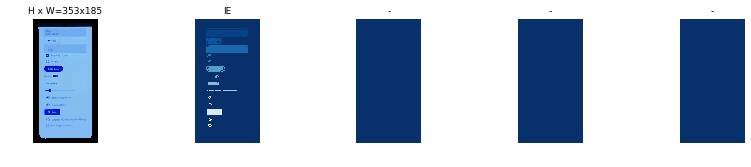

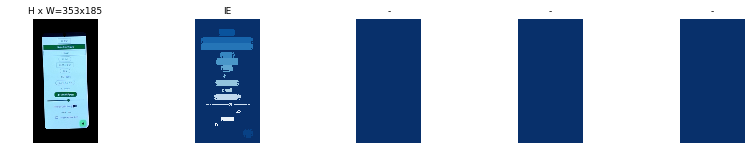

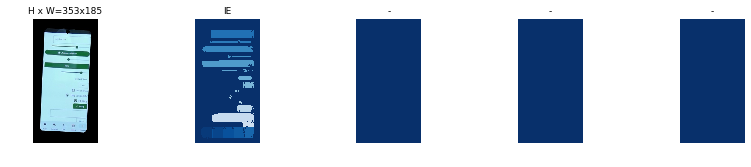

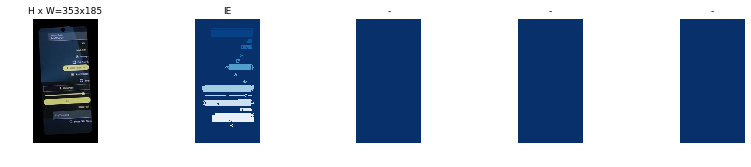

In [8]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    # Next line applies augmentation settings to input image. Used to test these settings.
    # Does not apply augmentation to masks which is why there are not rotated.
    image = config.AUGMENTATION(image=dataset_train.load_image(image_id))
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [9]:
# Create model in training mode.
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [10]:
# Which weights to start with?

if config.INIT_WITH == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif config.INIT_WITH == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes.
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif config.INIT_WITH == "last":
    # Load the last model you trained and continue training.
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO for).

2. Fine-tune all layers.

In [11]:
config.EPOCHS=20
config.LAYERS='heads'

model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=config.EPOCHS, 
            layers=config.LAYERS,
            augmentation=config.AUGMENTATION,
            custom_callbacks=[wandb.keras.WandbCallback()])

wandb: WARNING Keras version 2.0.8 is not fully supported. Required keras >= 2.4.0



Starting at epoch 0. LR=0.001

Checkpoint Path: /tf/logs/interactiveelements20221202T1619/mask_rcnn_interactiveelements_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mr

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/20
 999/1000 [============================>.] - ETA: 0s - loss: 1.7227 - rpn_class_loss: 0.1397 - rpn_bbox_loss: 0.7166 - mrcnn_class_loss: 0.2243 - mrcnn_bbox_loss: 0.2451 - mrcnn_mask_loss: 0.3969

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:2142: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
wandb: ERROR Can't save model, h5py returned error: can't pickle SwigPyObject objects


1000/1000 [==============================] - 308s - loss: 1.7222 - rpn_class_loss: 0.1396 - rpn_bbox_loss: 0.7164 - mrcnn_class_loss: 0.2243 - mrcnn_bbox_loss: 0.2450 - mrcnn_mask_loss: 0.3969 - val_loss: 1.2416 - val_rpn_class_loss: 0.0836 - val_rpn_bbox_loss: 0.5222 - val_mrcnn_class_loss: 0.1614 - val_mrcnn_bbox_loss: 0.1395 - val_mrcnn_mask_loss: 0.3348
Epoch 2/20
1000/1000 [==============================] - 252s - loss: 1.2402 - rpn_class_loss: 0.0738 - rpn_bbox_loss: 0.5352 - mrcnn_class_loss: 0.1567 - mrcnn_bbox_loss: 0.1437 - mrcnn_mask_loss: 0.3308 - val_loss: 1.0716 - val_rpn_class_loss: 0.0597 - val_rpn_bbox_loss: 0.4511 - val_mrcnn_class_loss: 0.1373 - val_mrcnn_bbox_loss: 0.1151 - val_mrcnn_mask_loss: 0.3084
Epoch 3/20
1000/1000 [==============================] - 250s - loss: 1.1114 - rpn_class_loss: 0.0614 - rpn_bbox_loss: 0.4773 - mrcnn_class_loss: 0.1372 - mrcnn_bbox_loss: 0.1187 - mrcnn_mask_loss: 0.3168 - val_loss: 0.9609 - val_rpn_class_loss: 0.0517 - val_rpn_bbox_lo

In [12]:
config.EPOCHS=40
config.LAYERS="all"

model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=config.EPOCHS,
            layers=config.LAYERS,
            augmentation=config.AUGMENTATION,
            custom_callbacks=[wandb.keras.WandbCallback()])


Starting at epoch 20. LR=0.0001

Checkpoint Path: /tf/logs/interactiveelements20221202T1619/mask_rcnn_interactiveelements_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)


wandb: Network error resolved after 0:02:14.875993, resuming normal operation.
wandb: Network error resolved after 0:03:13.715169, resuming normal operation.
wandb: Network error resolved after 0:03:24.558556, resuming normal operation.


In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [ ]:
class InferenceConfig(IEConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode.
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights.
# Either set a specific path or find last trained weights.
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights.
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
# Test on random images of validation dataset.
for i in range(5):
    image_id = random.choice(dataset_val.image_ids)
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False,
                               augmentation=config.AUGMENTATION)

    results = model.detect([original_image], verbose=1)

    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(16, 16))

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 100)
APs = []
for image_id in image_ids:
    # Load image and ground truth data.
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection.
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP.
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

In [ ]:
wandb.finish()

In [ ]:
# IP adress of device capturing images.
CAMERA_HOST = "192.168.1.100"
# Port on which the server for capturing is listening.
CAMERA_PORT = 1300

import socket
import json
import base64
from io import BytesIO
from PIL import Image
from IPython.display import clear_output

def getImageFromServer():
    for i in range(100):
        try:
            client = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
            client.settimeout(1)

            client.connect((CAMERA_HOST, CAMERA_PORT))
            request = {"header": "raw"}
            client.sendall((json.dumps(request) + "\n").encode())
            image_base64 = client.makefile().readline()
            image_bytes = base64.b64decode(image_base64)
            image_file = BytesIO(image_bytes)
            image = Image.open(image_file)
            return image
        except:
            print("Connection refused:", i, "/", 100)
            continue
    
    
while(True):
    image = getImageFromServer()
    image = np.array(image)
    
    r = model.detect([image], verbose=0)[0]
    clear_output(wait=True)
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(16, 16))